# MODELING

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools

import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
import torch.optim as optim

#### Add Mac acceleration

In [3]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


### Dataset class

In [4]:
class MultiParticipantDataset(Dataset):
    def __init__(self, df, seq_length, target_col='mood', id_col='id_num', include_target_in_features=True):
        """
        df: pandas DataFrame sorted by time.
        seq_length: number of time steps in each sample.
        target_col: the column we want to predict.
        """
        df = df.drop(columns=["next_day", "next_day_mood", "date"])
        
        self.seq_length = seq_length
        self.target_col = target_col
        self.id_col = id_col
        
        df.sort_values(by=[id_col, 'day'], inplace=True)
        self.data = df.reset_index(drop=True)

        if include_target_in_features:
            self.features = [col for col in self.data.columns if col not in [target_col, "day"]]
        else:
            self.features = [col for col in self.data.columns if col not in [target_col, id_col, "day"]]

        # Precompute valid indices where the sequence is within the same participant.
        self.valid_indices = []
        for i in range(len(self.data) - self.seq_length):
            participant_id = self.data.iloc[i][self.id_col]
            if all(self.data.iloc[i:i+self.seq_length][self.id_col] == participant_id):
                self.valid_indices.append(i)

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Use precomputed valid index.
        real_idx = self.valid_indices[idx]
        row = self.data.iloc[real_idx]
        participant_id = row[self.id_col]
        
        x_features = self.data.iloc[real_idx:real_idx+self.seq_length][self.features].values.astype(np.float32)
        x_id = np.array([participant_id] * self.seq_length, dtype=np.int64)
        
        # The target is the next time step's mood
        y = self.data.iloc[real_idx+self.seq_length][self.target_col]
        
        return torch.tensor(x_features),torch.tensor(x_id), torch.tensor(y).float()


### Load df

In [5]:
df_interpolated = pd.read_csv("tables/preprocessed/df_interpolated.csv")

### Train test split

In [6]:



dfs_train = []
dfs_test = []
proportion_train = 0.8
for participant, group in df_interpolated.groupby('id_num'):
    group = group.sort_values(by='day')
    split_idx = int(len(group) * proportion_train)
    dfs_train.append(group.iloc[:split_idx])
    dfs_test.append(group.iloc[split_idx:])
    
train_df = pd.concat(dfs_train)
test_df = pd.concat(dfs_test)

# get mood descriptives
print("Train mood descriptives")
print(train_df["mood"].describe())
print("Test mood descriptives")
print(test_df["mood"].describe())

# get the start end end dates per participant per df
train_start_dates = train_df.groupby('id_num')['day'].min()
train_end_dates = train_df.groupby('id_num')['day'].max()
test_start_dates = test_df.groupby('id_num')['day'].min()
test_end_dates = test_df.groupby('id_num')['day'].max()

# put in a dataframe with participant train start end and test start end
dates_df = pd.DataFrame({
    "participant": train_start_dates.index,
    "train_start": train_start_dates.values,
    "train_end": train_end_dates.values,
    "test_start": test_start_dates.values,
    "test_end": test_end_dates.values,
})

dates_df.to_csv("tables/training_dates_split.csv", index=False)

Train mood descriptives
count    1024.000000
mean        6.994181
std         0.731078
min         3.000000
25%         6.600000
50%         7.000000
75%         7.500000
max         9.333333
Name: mood, dtype: float64
Test mood descriptives
count    272.000000
mean       7.014920
std        0.733379
min        4.800000
25%        6.666667
50%        7.000000
75%        7.500000
max        9.000000
Name: mood, dtype: float64


### Normalize

In [32]:
def normalize(df, scaler=None, scaler_target=None, transform_target=False):

    df = df.copy()
    features = [col for col in df.columns if col not in ['id_num', 'day', "date", "next_day_mood", "next_day", "mood"]]
    
    if scaler is None:
        scaler = StandardScaler()
    
    # Scale the features
    df[features] = scaler.fit_transform(df[features])
    
    if transform_target:
        if scaler_target is None:
            scaler_target = StandardScaler()
        # Scale only the target column "mood"
        df["mood"] = scaler_target.fit_transform(df[["mood"]])

        # print("scaler properties:")
        # print(scaler.mean_)
        # print(scaler.scale_)
        print("scaler_target properties:")
        print(scaler_target.mean_)
        print(scaler_target.scale_)
        
        return df, scaler, scaler_target
    else:
        return df, scaler, None

def denormalize(df, scaler, scaler_target=None):

    features = [col for col in df.columns if col not in ['id_num', 'day', "date", "next_day_mood", "next_day", "mood"]]
    
    # Inverse transform the features
    df[features] = scaler.inverse_transform(df[features])
    
    if scaler_target is not None:
        # Inverse transform the target column "mood"
        df["mood"] = scaler_target.inverse_transform(df[["mood"]])
    
    return df

# Normalize the training and test data
train_df_normalized, scaler, scaler_target = normalize(train_df, scaler=None, scaler_target=None, transform_target=False)
test_df_normalized, _, _ = normalize(test_df, scaler=scaler, scaler_target=scaler_target) 

print(f"Train shape: {train_df_normalized.shape}, Test shape: {test_df_normalized.shape}") # Train shape: (1230, 24), Test shape: (307, 24)



Train shape: (1024, 29), Test shape: (272, 29)


### Create dataset

In [33]:

# Create the dataset
seq_length = 1
batch_size = 32
train_dataset = MultiParticipantDataset(train_df_normalized, seq_length=seq_length)
test_dataset = MultiParticipantDataset(test_df_normalized, seq_length=seq_length)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shape of the data
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")
for x, x_id, y in train_loader:
    print(f"x shape: {x.shape}, x_id shape: {x_id.shape}, y shape: {y.shape}")
    break
# 32 sequences in a batch, each with 5 time steps and 24 features


Number of batches in train_loader: 32
Number of batches in test_loader: 9
x shape: torch.Size([32, 1, 24]), x_id shape: torch.Size([32, 1]), y shape: torch.Size([32])


### define lstm model

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer; batch_first=True expects input shape: (batch, seq, feature)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Fully-connected layer to output the final prediction
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x: [batch_size, seq_length, input_dim]
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step's output for prediction
        out = self.fc(out[:, -1, :])
        return out

### Train loop

Epoch [1/40], Train Loss: 48.2736, Eval Loss: 45.8951
Epoch [2/40], Train Loss: 40.9791, Eval Loss: 34.2766
Epoch [3/40], Train Loss: 25.5605, Eval Loss: 16.8861
Epoch [4/40], Train Loss: 11.6092, Eval Loss: 6.5837
Epoch [5/40], Train Loss: 4.7987, Eval Loss: 2.7025
Epoch [6/40], Train Loss: 2.2212, Eval Loss: 1.4146
Epoch [7/40], Train Loss: 1.3140, Eval Loss: 0.9972
Epoch [8/40], Train Loss: 0.9926, Eval Loss: 0.8541
Epoch [9/40], Train Loss: 0.8650, Eval Loss: 0.7930
Epoch [10/40], Train Loss: 0.8013, Eval Loss: 0.7571
Epoch [11/40], Train Loss: 0.7609, Eval Loss: 0.7307
Epoch [12/40], Train Loss: 0.7311, Eval Loss: 0.7094
Epoch [13/40], Train Loss: 0.7074, Eval Loss: 0.6917
Epoch [14/40], Train Loss: 0.6879, Eval Loss: 0.6766
Epoch [15/40], Train Loss: 0.6714, Eval Loss: 0.6637
Epoch [16/40], Train Loss: 0.6572, Eval Loss: 0.6525
Epoch [17/40], Train Loss: 0.6450, Eval Loss: 0.6427
Epoch [18/40], Train Loss: 0.6343, Eval Loss: 0.6340
Epoch [19/40], Train Loss: 0.6249, Eval Loss: 0.

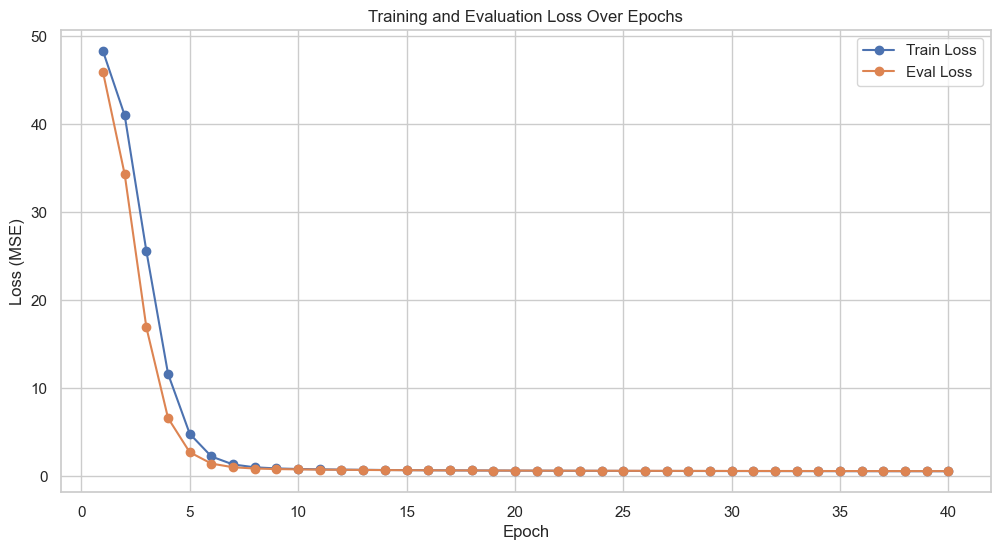

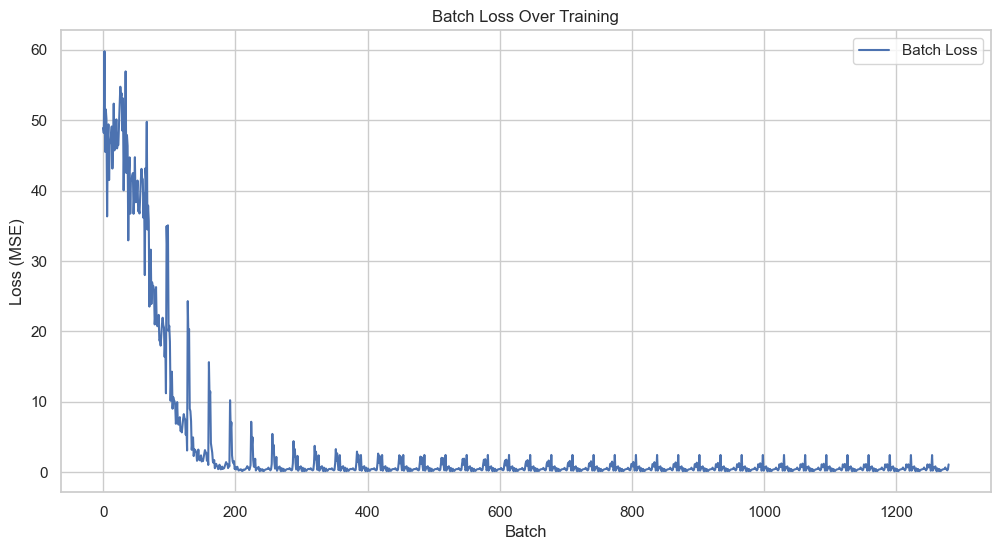

In [36]:
# Hyperparameters
input_dim = len(train_dataset.features)  # e.g., 24
hidden_dim = 32             # Number of LSTM units
num_layers = 2
output_dim = 1                   # For regression (predicting a single value)
num_epochs = 40
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare lists to store loss values for plotting
train_epoch_losses = []
eval_epoch_losses = []
batch_losses = []

# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    train_loss_epoch = 0.0

    # --- Training ---
    for batch in train_loader:
        x_features, x_id, y = batch  # x_features: [batch, seq_length, input_dim]
        
        # Forward pass
        outputs = model(x_features)  # outputs shape: [batch, output_dim]
        loss = criterion(outputs.squeeze(), y)

        batch_losses.append(loss.item())
        
        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_epoch += loss.item()
    
    avg_train_loss = train_loss_epoch / len(train_loader)
    train_epoch_losses.append(avg_train_loss)
    
    # --- Evaluation ---
    model.eval()
    eval_loss_epoch = 0.0
    with torch.no_grad():
        for batch in test_loader:
            x_features, x_id, y = batch
            outputs = model(x_features)
            loss = criterion(outputs.squeeze(), y)
            eval_loss_epoch += loss.item()
    
    avg_eval_loss = eval_loss_epoch / len(test_loader)
    eval_epoch_losses.append(avg_eval_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}")

# Plot the training and evaluation loss curves
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs+1), train_epoch_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), eval_epoch_losses, label='Eval Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Evaluation Loss Over Epochs")
plt.legend()
plt.show()

# plot batch losses
plt.figure(figsize=(12, 6))
plt.plot(batch_losses, label='Batch Loss')
plt.xlabel("Batch")
plt.ylabel("Loss (MSE)")
plt.title("Batch Loss Over Training")
plt.legend()
plt.show()


### Predict and plot function

In [15]:

def predict_and_plot(model, data_loader, test_dataset, target_scaler=None, show_plot=True, save_html=True, title="predictions"):
    """
    Runs predictions on the data_loader using model, builds a results DataFrame using the
    test_dataset's original data (which includes the 'day' and 'id_num' columns), and then plots
    real vs predicted values with Plotly using the 'day' column for the x-axis and a dropdown
    to select different participants.

    Parameters:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset to predict on.
        test_dataset: The dataset instance (e.g., MultiParticipantDataset) used to create data_loader.
                      It must have a 'data' attribute containing the original DataFrame with a 'day' column.
        target_scaler: (Optional) Scaler used to normalize the target data.
    """
    model.eval()
    all_predictions = []
    all_targets = []
    
    # Run model predictions over the data_loader
    with torch.no_grad():
        for batch in data_loader:
            x_features, x_id, y = batch
            outputs = model(x_features)
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    
    # Concatenate all predictions and targets into arrays.
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)

    
    # Inverse transform if a target scaler is provided.
    if target_scaler is not None:
        print("Target scaler mean:", target_scaler.mean_)
        print("Target scaler scale:", target_scaler.scale_)
        all_predictions = target_scaler.inverse_transform(all_predictions)
        all_targets = target_scaler.inverse_transform(all_targets.reshape(-1, 1))
    

    # Compute the correct slice of the original DataFrame.
    # The i-th prediction corresponds to data row at index (i + seq_length)
    start_idx = test_dataset.seq_length
    end_idx = start_idx + len(test_dataset)
    df_results = test_dataset.data.iloc[start_idx:end_idx].copy().reset_index(drop=True)

    # Add prediction and target columns to the results DataFrame.
    df_results['Real'] = all_targets.reshape(-1)
    df_results['Predicted'] = all_predictions.reshape(-1)
    
    # Get unique participant IDs from the results DataFrame.
    participant_col = test_dataset.id_col  # e.g., 'id_num'
    participants = df_results[participant_col].unique()
    
    # Build Plotly traces for each participant: two traces (real & predicted) per participant.
    traces = []
    for p in participants:
        df_p = df_results[df_results[participant_col] == p]
        traces.append(go.Scatter(
            x=df_p['day'],
            y=df_p['Real'],
            mode='lines',
            name=f'Real ({p})',
            visible=False  # We'll control visibility via the dropdown.
        ))
        traces.append(go.Scatter(
            x=df_p['day'],
            y=df_p['Predicted'],
            mode='lines',
            name=f'Predicted ({p})',
            visible=False
        ))
    
    total_traces = len(traces)  # Should be 2 * number of participants.
    
    # Create dropdown buttons. Each button sets visibility so that only the two traces for one participant are shown.
    dropdown_buttons = []
    for i, p in enumerate(participants):
        visibility = [False] * total_traces
        # For participant p, set traces at indices 2*i and 2*i+1 to True.
        visibility[2*i] = True
        visibility[2*i+1] = True
        button = dict(
            label=str(p),
            method="update",
            args=[{"visible": visibility},
                  {"title": f"Real vs Predicted Mood Values for Participant {p}",
                   "xaxis": {"title": "Day"},
                   "yaxis": {"title": "Mood Value"}}]
        )
        dropdown_buttons.append(button)
    
    # Set the initial visibility: show the first participant.
    initial_visibility = [False] * total_traces
    initial_visibility[0] = True
    initial_visibility[1] = True
    for i in range(total_traces):
        traces[i].visible = initial_visibility[i]
    
    # Build the figure with all traces and add the dropdown menu.
    fig = go.Figure(data=traces)
    fig.update_layout(
        updatemenus=[
            dict(
                active=0,
                buttons=dropdown_buttons,
                x=1.1,
                y=1.0,
                showactive=True
            )
        ],
        title=f"Real vs Predicted Mood Values for Participant {participants[0]}",
        xaxis_title="Day",
        yaxis_title="Mood Value"
    )
    
    if show_plot:
        fig.show()
    if save_html:
        outdir = "figures/plotly/predictions"
        os.makedirs(outdir, exist_ok=True)
        fig.write_html(os.path.join(outdir, f"predictions_{title}.html"))



### Plot predictions

In [37]:
# Call the function to predict and plot
# predict_and_plot(model, train_loader, train_dataset, target_scaler=scaler_target, show_plot=True, save_html=True, title="train")
predict_and_plot(model, test_loader, test_dataset, target_scaler=scaler_target, show_plot=True, save_html=True, title="test")